# **Time Series - Forecasting Stock Prices**
----------------
## **Context:** 
----------------

**Stocks are one of the most popular financial instruments invented for building wealth** and are the **centerpiece of any investment portfolio.** Recent advances in trading technology have opened up stock markets in such a way that nowadays, **nearly anybody can own stock.** 

In the last few decades, there's been an **explosive increase in the average person's interest for the stock market.** This makes stock value prediction an interesting and popular problem to explore.


------------------
## **Objective:**
------------------

Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America as well as internationally. This dataset consists of monthly average stock closing prices of Amazon over a period of 12 years from 2006 to 2017. The purpose is to **build a time series model** using the AR, MA, ARMA and ARIMA models in order to **forecast the stock closing price of Amazon.**

--------------------------
## **Data Dictionary:**
--------------------------
- **date:** Date when the price was collected
- **close:** Closing price of the stock

### Import libraries

In [ ]:
!pip install statsmodels==0.12.1

In [ ]:
# Version check 
import statsmodels
statsmodels.__version__

'0.12.1'

In [ ]:
# Import libraries for data manipulation
import pandas as pd
import numpy as np

# Import libraries for visualization
import matplotlib.pylab as plt
import seaborn as sns

# Import library for date manipulation
from datetime import datetime

# calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

# Import acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

### Read the dataset

In [ ]:
# If having an issue while loading the excel file in pandas,
# run the below command in anaconda prompt, otherwise ignore.
# conda install -c anaconda xlrd

In [ ]:
df = pd.read_excel('amazon_stocks_prices.xlsx')
df.head()

,date,close
0,2006-01-01,45.22
1,2006-02-01,38.82
2,2006-03-01,36.38
3,2006-04-01,36.32
4,2006-05-01,34.13


### Check info 

### **Check the info of the dataset and write your observations.**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    144 non-null    datetime64[ns]
 1   close   144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


**Observations:**
* **1. Small dataset** - It's only 144 rows and 2 columns. Very small dataset to run without worry about the time and memory needed (2.4 KB only).
* **2. Non-missing data** - It's 144 entries with all non-null in both data and close columns. No need to deal with missing data.
* **3. Datatype ready** - The data type of date is datetime64, which is ready to use. Otherwise, in the later operation we may see "NotImplementedError" if not ready for datatime. Now we don't need to change it.
* **4. Index with "date"** - We only need the closing price to conduct the time series analysis. We will make the "date" column into the index afterward.

In [ ]:
# Set date as the index
df = df.set_index(['date'])
df.head()

,close
date,
2006-01-01,45.22
2006-02-01,38.82
2006-03-01,36.38
2006-04-01,36.32
2006-05-01,34.13


**visualize the time series** to get an idea about the trend and/or seasonality within the data.

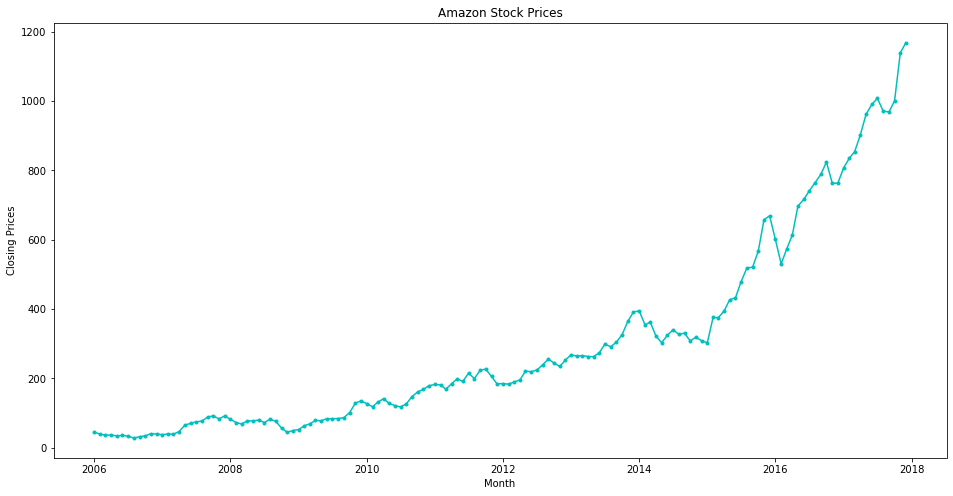

In [ ]:
# Visualize the time series
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Closing Prices")
plt.title('Amazon Stock Prices')
plt.plot(df.index, df.close, color = 'c', marker='.')

**Observations:**
- We can see that the series has an **upward trend with some seasonality.** This implies that the **average stock price of Amazon has been increasing almost every year.**
- Before building different models, it is important to **check whether the series is stationary or not.**

Split the dataset into train and test data

### Split the dataset

In [ ]:
# Split the data into train and test
df_train = df.loc['2006-01-01':'2015-12-01']
df_test = df.loc['2016-01-01' : '2017-12-01']
print(df_train)
print(df_test)

             close
date              
2006-01-01   45.22
2006-02-01   38.82
2006-03-01   36.38
2006-04-01   36.32
2006-05-01   34.13
...            ...
2015-08-01  518.46
2015-09-01  520.96
2015-10-01  566.74
2015-11-01  657.70
2015-12-01  669.26

[120 rows x 1 columns]
              close
date               
2016-01-01   601.06
2016-02-01   530.62
2016-03-01   572.37
2016-04-01   613.59
2016-05-01   697.47
2016-06-01   716.39
2016-07-01   741.47
2016-08-01   764.84
2016-09-01   788.97
2016-10-01   824.44
2016-11-01   763.34
2016-12-01   763.33
2017-01-01   807.51
2017-02-01   835.75
2017-03-01   854.24
2017-04-01   903.39
2017-05-01   961.72
2017-06-01   990.44
2017-07-01  1008.48
2017-08-01   971.44
2017-09-01   968.99
2017-10-01  1000.72
2017-11-01  1139.81
2017-12-01  1168.84


Check the **rolling mean and standard deviation** of the series to **visualize if the series has any trend or seasonality.**

### Test the stationarity of the series

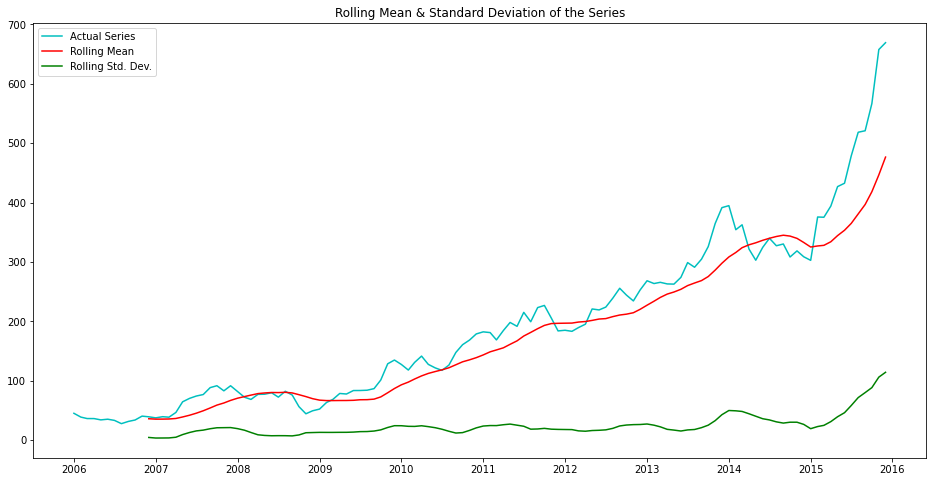

In [ ]:
# Calculate the rolling mean and standard deviation for a window of 12 observations
rolmean=df_train.rolling(window=12).mean()
rolstd=df_train.rolling(window=12).std()

#Visualize the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df_train, color='c', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 
rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

**Observations:**
- We can see there is an upward trend in the series.
- We can confirm that **the series is not stationary.**

We can also use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [ ]:
# Define a function to use adfuller test
def adfuller(df_train):
  # Import adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df_train['close'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(df_train)

Dickey-Fuller Test: 
Test Statistic            3.464016
p-value                   1.000000
Lags Used                 0.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:**
1. From the above test, we can see that the **p-value = 1 i.e. > 0.05** (For 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Hence, **we can confirm that the series is non-stationary.**

### Make the series stationary

We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation**
2. **By differencing the series (lagged series)**

Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

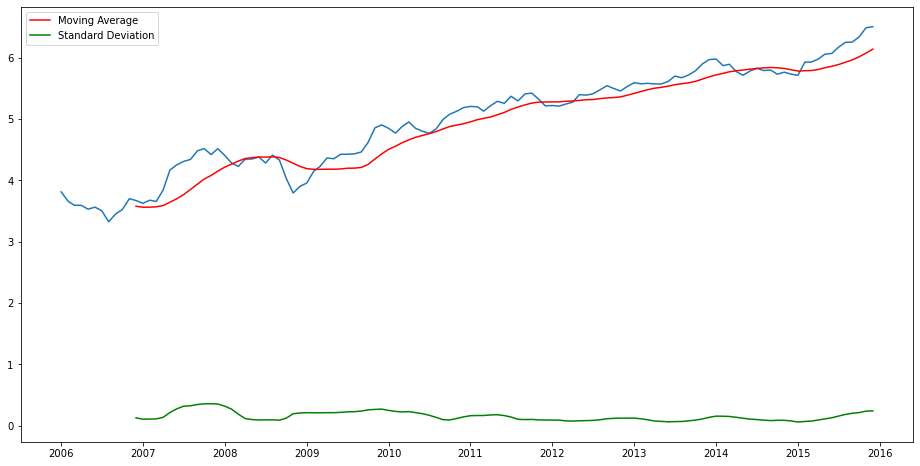

In [ ]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df_train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

**Observations:**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant which implies that **now the series has constant variance.**

**Shift the series by order 1 (or by 1 month) & apply differencing (using lagged series)** and then check the rolling mean and standard deviation.

### **Visualize the rolling mean and rolling standard deviation of the shifted series (df_shift) and check the stationarity by calling the adfuller() function.**

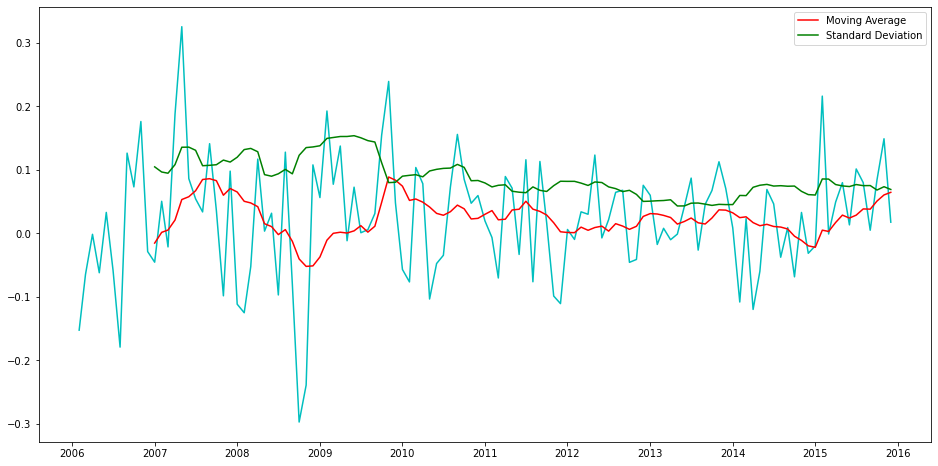

In [ ]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window = 12).mean()
MStd_shift = df_shift.rolling(window = 12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

# Drop the null values that we get after applying differencing method
df_shift = df_shift.dropna()

call the adfuller function for df_shift series
Use the adfuller test to check the stationarity

In [1]:
adfuller(df_shift) 

NameError: ignored

**Observations:**
1. From the above test, we can see that the **p-value = 5.45 i.e. > 0.05** (For 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Hence, **we can confirm that the series is non-stationary**

Decompose the time series to check its different components.

### Decompose the time series components into Trend, Seasonality and Residual

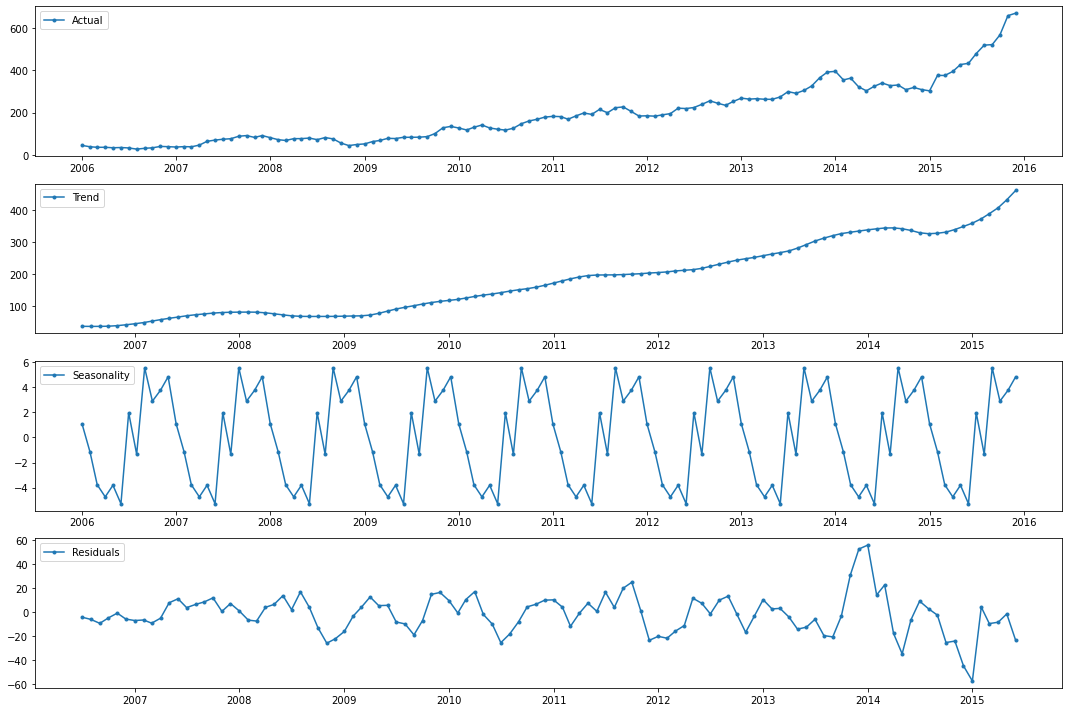

In [ ]:
# Import the seasonal_decompose function to decompose the time series

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(df_train, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

**Observations:**
- We can see that there are significant **trend, seasonality and residuals components** in the series
- The plot for seasonality shows that **Amazon's stock prices spike in July, September, and December.**

**Move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q i.e. order of AR and MA models to be used.**

### Plot the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models

<Figure size 1152x576 with 0 Axes>

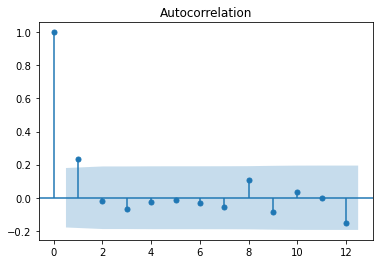

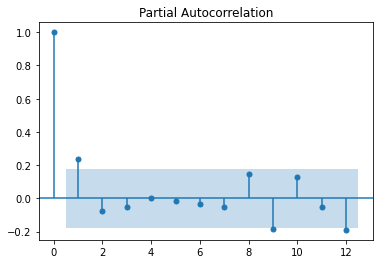

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 12) 
plt.show() 
plot_pacf(df_shift, lags = 12) 
plt.show()

**Observations:**
- From the above PACF plot we can see that **the highest lag** at which the plot extends beyond the statistically significant boundary is **lag 1.** 
- This indicates that an **AR Model of lag 1 (p=1)** should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that **q=1.**

### AR Model

### **Fit and predict the shifted series with the AR Model and calculate the RMSE.**

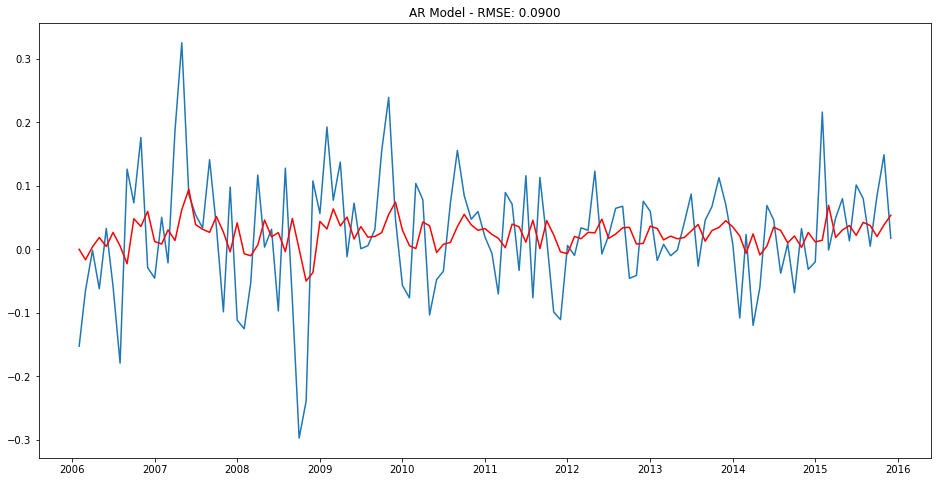

In [ ]:
# Import AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=[1]) #Use number of lags as 1 and apply AutoReg function on df_shift series
results_AR = model_AR.fit() #fit the model
plt.plot(df_shift)
predict = results_AR.predict() #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict,df_shift['close'], squared=False))  #Calculating rmse
plt.show()

**Observations:**
* **1)RMSE** It's 0.09. Pretty small. Since RMSE the smaller the better, we would be pretty much satisifed about the AR model when p = 1 (lags = 1)**

**Check the AIC value** of the model

In [ ]:
results_AR.aic

-4.781419615400342

Now, let's build MA, ARMA, and ARIMA models as well, and see if we can get a better model 

### MA Model

**Use an ARIMA model with p=0 and d=0 so that it will work as an MA model**

### **Fit and predict the shifted series with the MA Model and calculate the RMSE**

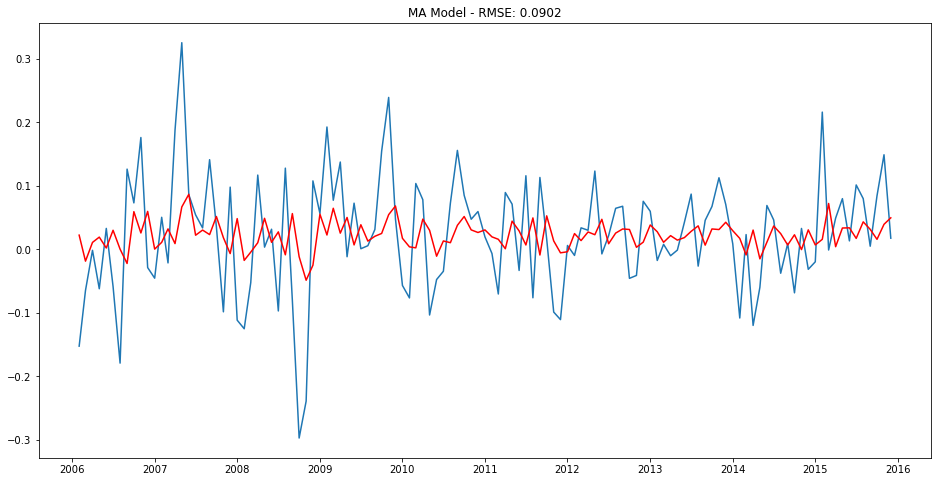

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order = (0, 0, 1)) #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_MA = model_MA.fit(disp=0) #fit the model
plt.plot(df_shift)
plt.plot(results_MA.predict(), color = 'red')

plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**
* **1.RMSE** - It's still 0.0902, almost the same as the MA model (0.0900). 
* **2.q=1** It looks like the RSME is still good enough, but does not change too much.

Check the AIC value of the model

In [ ]:
results_MA.aic

-229.09493930954125

- **The MA model is giving a much lower AIC** when compared to the AR model, implying that **the MA model fits the training data better.** 

### ARMA Model

We will be using an **ARIMA model with p=1 and q=1** (as observed from the ACF and PACF plots) **and d=0 so that it will work as an ARMA model.**

### **Fit and predict the shifted series with the ARMA Model and calculate the RMSE**

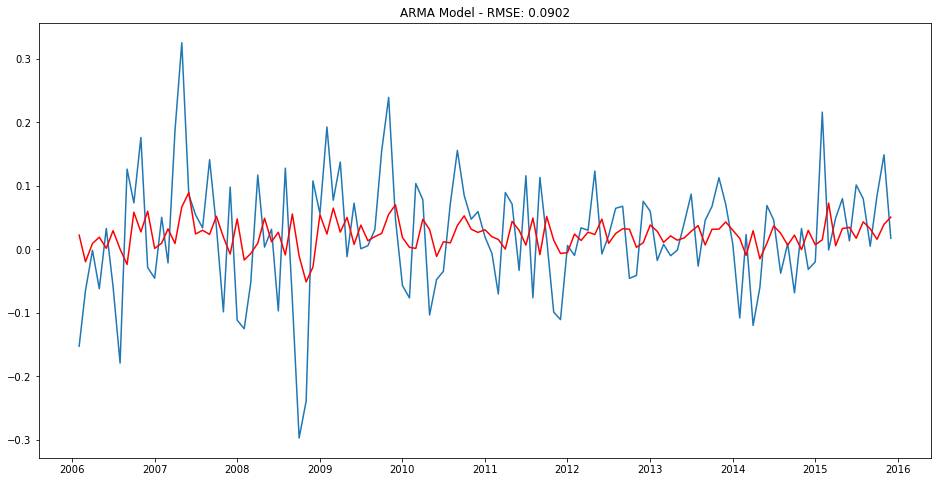

In [ ]:
plt.figure(figsize=(16,8))
# Use p=1, d=0, q=1 and apply ARIMA function on df_shift series
model_ARMA = ARIMA(df_shift, order = (1, 0 , 1)) 

# fit the model
results_ARMA = model_ARMA.fit(disp=0) 
plt.plot(df_shift)
plt.plot(results_ARMA.predict(), color='red')
plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**
* **RMSE** - It's again 00902, exactly the same as AR model (0.0902) and almost the same as MA model (0.0900).**

**Check the AIC value** of the model

In [ ]:
results_ARMA.aic

-227.11129236959925

- **The AIC value of the ARMA model is more or less similar** to MA model 

**Use the ARIMA Model.**

### ARIMA Model

Use an **ARIMA Model with p=1, d=1, & q=1**.

### **Fit and predict the shifted series with the ARIMA Model and calculate the RMSE**

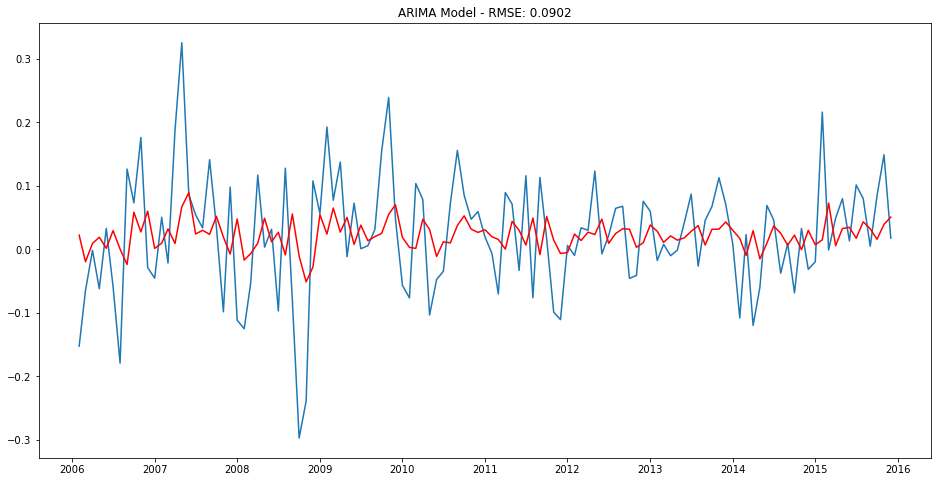

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(16,8))
# Use p=1, d=1, q=1 and apply ARIMA function on df_log series
model_ARIMA = ARIMA(df_log, order = (1, 1, 1)) 
# fit the model
results_ARIMA = model_ARIMA.fit(disp = 0) 
plt.plot(df_shift)
plt.plot(results_ARIMA.predict(), color='red')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues, df_shift['close'], squared=False))
plt.show()

**Observations:**
* **RMSE** - It's again 00902, exactly the same as ARMA model (0.0902), AR model (0.0902) and almost the same as MA model (0.0900)**

**Check the AIC value** of the model

In [ ]:
results_ARIMA.aic

-227.11129236959925

- **The AIC value of the ARIMA model is the same** as the ARMA model. 

We can see that **all the models return almost the same RMSE.** There is not much difference in AIC value as well across all the models except for the AR model.

**We can choose to predict the values using ARIMA as it takes into account more factors than AR, MA, ARMA models.**

In [ ]:
# Print the fitted values
predictions=pd.Series(results_ARIMA.fittedvalues)
predictions

date
2006-02-01    0.022235
2006-03-01   -0.019667
2006-04-01    0.009184
2006-05-01    0.018985
2006-06-01    0.001615
                ...   
2015-08-01    0.043234
2015-09-01    0.032286
2015-10-01    0.015696
2015-11-01    0.039276
2015-12-01    0.050567
Length: 119, dtype: float64

### Inverse Transformation

Now we have fitted values using the ARIMA model, **we will use the inverse transformation to get back the original values.**

### **Apply an inverse transformation on the predictions of the ARIMA Model.**

In [ ]:
# First step - doing cumulative sum
# use .cumsum fuction on the predictions
predictions_cumsum = np.cumsum(results_ARIMA.predict()) 
predictions_cumsum

2006-02-01    0.022235
2006-03-01    0.002568
2006-04-01    0.011753
2006-05-01    0.030738
2006-06-01    0.032353
                ...   
2015-08-01    2.526099
2015-09-01    2.558385
2015-10-01    2.574081
2015-11-01    2.613357
2015-12-01    2.663925
Freq: MS, Length: 119, dtype: float64

In [ ]:
# Second step - Adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['close'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log

2006-01-01    3.811539
2006-02-01    3.833774
2006-03-01    3.814108
2006-04-01    3.823292
2006-05-01    3.842277
                ...   
2015-08-01    6.337638
2015-09-01    6.369925
2015-10-01    6.385620
2015-11-01    6.424897
2015-12-01    6.475464
Length: 120, dtype: float64

In [ ]:
# Third step - applying exponential transformation
# use exponential function
predictions_ARIMA = predictions_log.apply(np.exp) 
# predictions_ARIMA = np.exp(predictions_log)
predictions_ARIMA

2006-01-01     45.220000
2006-02-01     46.236724
2006-03-01     45.336292
2006-04-01     45.754601
2006-05-01     46.631546
                 ...    
2015-08-01    565.459301
2015-09-01    584.013810
2015-10-01    593.252707
2015-11-01    617.017218
2015-12-01    649.020397
Length: 120, dtype: float64

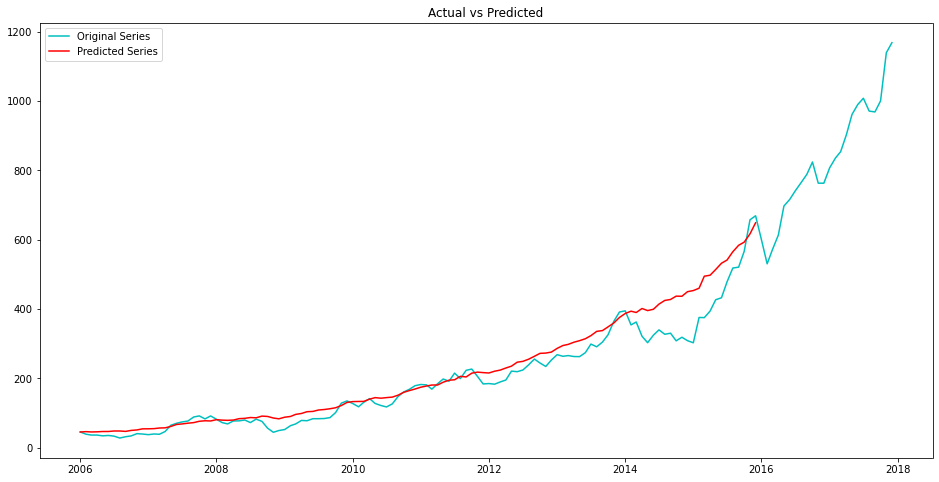

In [ ]:
# Plot the original vs predicted series
plt.figure(figsize=(16,8))
# plot the original train series
plt.plot(df, color = 'c', label = 'Original Series')  
# plot the predictions_ARIMA 
plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- We can see that **the predicted series is very similar to the original series** i.e. The model is good at predicting values on the training data except for the dip in stock prices in 2015 which may have been due to some external factors that are not included in this model. 
- Let us **forecast the closing prices for the next 24 months.**

### Forecast the values for next 24 months and compare it with test data

**To forecast the values for the next 24 months using the ARIMA model, we need to follow the steps below:**
1. Forecast the log-transformed fitted values for the next 24 months
2. Make a list of these 24 month (2016-2017) forecasted values
3. Convert that list into a series so that we can work with pandas functions 
4. Make a dataframe where we have the dates starting from 2016-01-01 to 2017-12-01 as the index and the respective forecasted values
5. Apply the inverse transformation and get the real forecasted values

### **Forecast the stocks prices for the next 24 months and perform the inverse transformation.**

In [ ]:
# Forecast the values for next 24 months
# forecast using the results_ARIMA for next 24 months. Keep steps=24
forecasted_ARIMA = results_ARIMA.forecast(24) 
forecasted_ARIMA[0]

array([6.52115938, 6.54310818, 6.56533181, 6.58756628, 6.60980117,
       6.63203609, 6.65427101, 6.67650592, 6.69874084, 6.72097575,
       6.74321067, 6.76544559, 6.7876805 , 6.80991542, 6.83215034,
       6.85438525, 6.87662017, 6.89885508, 6.92109   , 6.94332492,
       6.96555983, 6.98779475, 7.01002967, 7.03226458])

In [ ]:
# Create a list containing all the forecasted values
list1 = forecasted_ARIMA[0].tolist()
series1 = pd.Series(list1)
series1

0     6.521159
1     6.543108
2     6.565332
3     6.587566
4     6.609801
5     6.632036
6     6.654271
7     6.676506
8     6.698741
9     6.720976
10    6.743211
11    6.765446
12    6.787681
13    6.809915
14    6.832150
15    6.854385
16    6.876620
17    6.898855
18    6.921090
19    6.943325
20    6.965560
21    6.987795
22    7.010030
23    7.032265
dtype: float64

In [ ]:
# Make a new dataframe to get the additional dates from 2016-2018
index = pd.date_range('2016-01-1','2018-1-1' , freq='1M')- pd.offsets.MonthBegin(1)
df1 = pd.DataFrame()
df1['forecasted'] = series1
df1.index = index
df1

,forecasted
2016-01-01,6.521159
2016-02-01,6.543108
2016-03-01,6.565332
2016-04-01,6.587566
2016-05-01,6.609801
2016-06-01,6.632036
2016-07-01,6.654271
2016-08-01,6.676506
2016-09-01,6.698741
2016-10-01,6.720976


In [ ]:
# Apply exponential transformation to the forecasted log values
# Use exponential function on forecasted data
forecasted_ARIMA = df1.apply(np.exp) 
forecasted_ARIMA

,forecasted
2016-01-01,679.365569
2016-02-01,694.441679
2016-03-01,710.047455
2016-04-01,726.011806
2016-05-01,742.335409
2016-06-01,759.026044
2016-07-01,776.091951
2016-08-01,793.541567
2016-09-01,811.383519
2016-10-01,829.626629


Now, let's try to visualize the original data with the predicted values on the training data and the forecasted values.

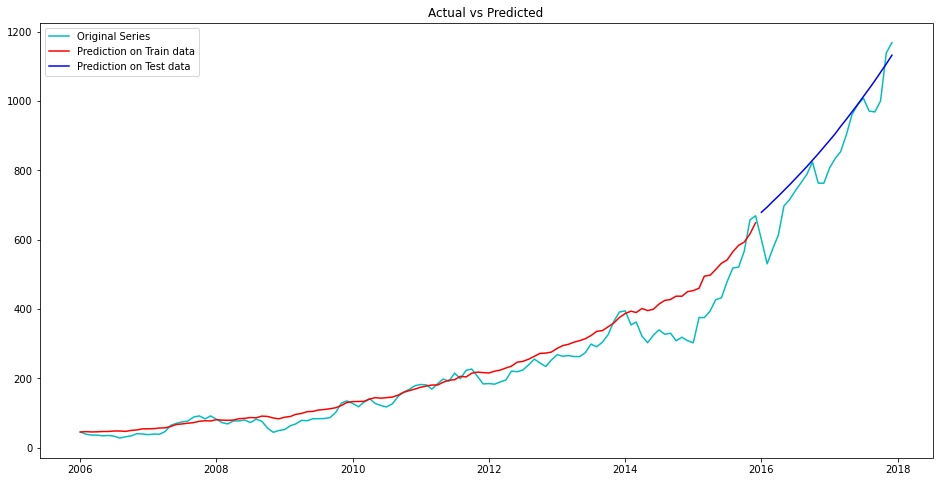

In [ ]:
# Plot the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df, color = 'c', label = 'Original Series')
# plot the predictions_ARIMA series
plt.plot(predictions_ARIMA, color = 'r', label = 'Prediction on Train data') 
# plot the forecasted_ARIMA series
plt.plot(forecasted_ARIMA, label = 'Prediction on Test data', color='b') 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- **As observed earlier, most of the predicted values on the training data are very close to the actual values** except for the dip in stock prices in the year 2015.
- **On the test data, the model is able to correctly predict the trend of the stock prices**, as we can see that the blue line appears to be close to the actual values (cyan blue) and they both have an upward trend. **However the test predictions are not able to identify the volatile variations in the stock prices over the last 2 years.**

Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not.

### **Check the RMSE on the original train and test data.**

In [ ]:
from sklearn.metrics import mean_squared_error
# calculate RMSE using the predictions_ARIMA and df_train 
error = mean_squared_error(predictions_ARIMA,df_train, squared = False) 
error

43.27251536342994

In [ ]:
from sklearn.metrics import mean_squared_error
# calculate RMSE using the forecasted_ARIMA and df_test
error = mean_squared_error(forecasted_ARIMA, df_test, squared = False)  
error

73.39357880819526

### Conclusion

**Conclusion**

* **1) Log Transformation helps** - We do log transformation and it helps to see the potential, though it's not yet stationary. It's a good technique when we're dealing with some financial time series data.
* **2) Shifted series helps** - It helps to see the potential to have d=1 in ARIMA though it's not yet stationary with only differencing.
* **3) RMSE difference not too much in AR, MA, ARMA, and ARIMA** - In our model comparison, it looks like the RMSE does not change too much during the 4 models and it's all-around 0.09.
* **4) AIC drops from AR model -4.7 to MA, ARMA, and ARIMA -227~-229** -  AIC value does not have much difference across all the models except for the AR model.
* **5) We choose ARIMA (1,1,1) model** - At the end, we choose to predict the values using ARIMA as it will consider more factors than AR, MA, ARMA models.
* **6) Our prediction works well** - Our final actual vs predicted plot looks perfectly to predict the stock price of Amazon in the 2016 and 2017 years. And we believe there is some special factor in 2015 but it's eventually still predictable.

